# Assignment 2
## Part 2: Scale-Space Blob Construction   
Mohammad Rashiqul Alam  
malam25@illinois.edu  

In [23]:
# Modules
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from   PIL import Image
from scipy.ndimage import gaussian_filter, gaussian_laplace, sobel
from skimage import filters, feature, util, color
from skimage.transform import resize

## Image Pre-Processing

### Import All ALigned Images
Import low-resolution images from ~/Gen/a2/lowres_rgb/preprocessed  
Import high-resolution images from ~/Gen/a2/hires_rgb/preprocessed

**Notebook assumes the output has been generated froma alam_rashiqul_a2_p1.pynb

In [24]:
# Import aligned images to notebook
def import_aligned_images(path, ext='jpg'):
    """
    Function to import aligned images from a specified directory, 
    only those ending with *_aligned.jpg.
    Args:
    - path: str, path to the directory containing images
    - ext: str, file extension of the images to import (default: 'jpg')
    Returns:
    - images: list of numpy arrays (each image)
    """
    images = []
    for file in os.listdir(path):
        if file.endswith(f"_aligned.{ext}"):
            img = Image.open(os.path.join(path, file))
            images.append(np.array(img))
    return images

# Plot aligned images
def plot_aligned_images(images, filenames=None, use_gray=False):
    """
    Function to plot all aligned images from the dataset.
    Args:
        images: list of numpy arrays (each image)
        filenames: list of filenames corresponding to images (optional)
        use_gray: bool, if True use grayscale colormap
    Returns:
        None
    """
    n = len(images)
    plt.figure(figsize=(2.5 * n, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        if use_gray:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i])
        plt.axis("off")
        if filenames:
            name = filenames[i].replace('_aligned.jpg', '').replace('_aligned.jpeg', '').replace('_aligned.png', '')
            ax.set_title(name, fontsize=10)
    plt.show()

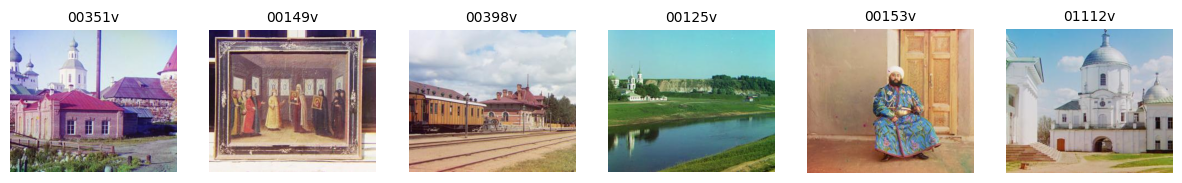

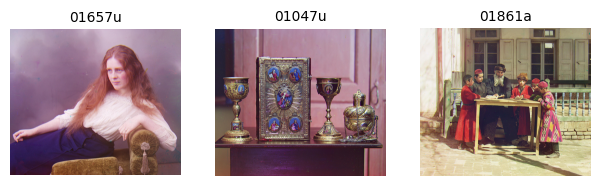

In [25]:
def safe_import_aligned_images(directory, ext='jpg'):
    """Import images and filenames if directory exists, else return empty lists."""
    if not os.path.isdir(directory):
        print(f"Directory does not exist: {directory}")
        return [], []
    images = import_aligned_images(directory, ext=ext)
    filenames = [f for f in os.listdir(directory) if f.endswith(f"_aligned.{ext}")]
    return images, filenames

# Get the directory one level above the notebook location
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
lowres_preproc_dir = os.path.join(parent_dir, "Gen", "a2", "part1", "lowres_rgb", "preprocessed")
highres_preproc_dir = os.path.join(parent_dir, "Gen", "a2", "part1", "hires_rgb", "preprocessed")

# Import and plot low-res images
low_res_images, low_res_filenames = safe_import_aligned_images(lowres_preproc_dir, ext='jpg')
if low_res_images:
    plot_aligned_images(low_res_images, low_res_filenames, use_gray=False)

# Import and plot high-res images
high_res_images, high_res_filenames = safe_import_aligned_images(highres_preproc_dir, ext='jpg')
if high_res_images:
    plot_aligned_images(high_res_images, high_res_filenames, use_gray=False)

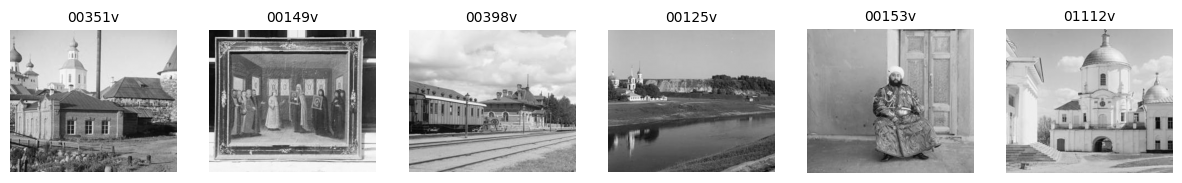

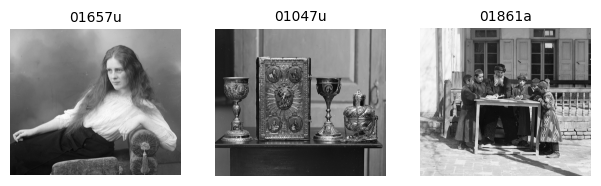

In [26]:
# Convert images to grayscale and rescale intensities to [0, 1]
low_res_gray = [np.array(Image.fromarray(img).convert('L')) / 255.0 for img in low_res_images]
high_res_gray = [np.array(Image.fromarray(img).convert('L')) / 255.0 for img in high_res_images]

# Plot gray-scale images
plot_aligned_images(low_res_gray, low_res_filenames, use_gray=True)
plot_aligned_images(high_res_gray, high_res_filenames, use_gray=True)

### Choice of Images for Part 2: Scale-Space Blob Construction

Selected four aligned images for this part of the assignment:
1. **00125v_aligned.jpg (Church by river)**  
   - Contains both natural features (trees, cliffs, river) and man-made structures (church buildings).  
   - Provides a mix of sharp corners and smoother regions, useful for testing corner detection and blob scale behavior.
2. **00351v_aligned.jpg (Brick house with domes)**  
   - Rich in architectural detail with windows, rooftops, and domes.  
   - Good distribution of corners and circular blob-like features at different scales.
3. **00398v_aligned.jpg (Train station with train cars)**  
   - Strong geometric patterns from train cars, station buildings, and tracks.  
   - Tests whether the method correctly preserves scale/orientation across repeating man-made structures.
4. **01047u_aligned.jpg (Chalices and book)**  
   - Objects with fine texture and small-scale blob-like details (ornamental designs, circular cups).  
   - Complements the larger-scale features in the other images with smaller, high-detail regions.

Selected image keys: dict_keys(['00125v', '00351v', '00398v', '01047u'])


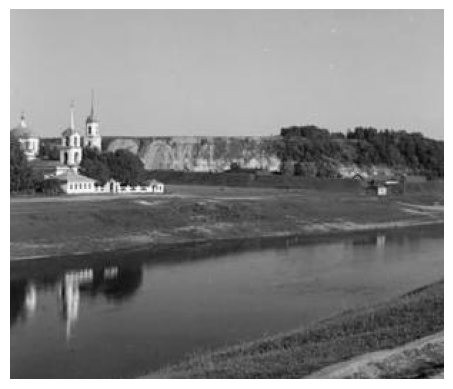

00125v


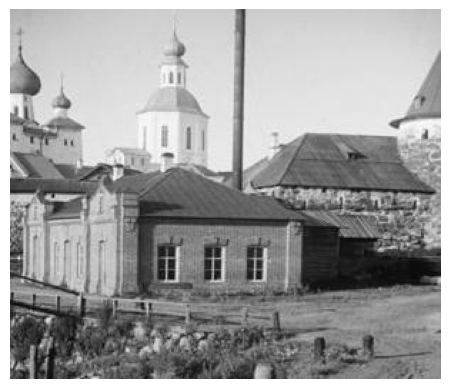

00351v


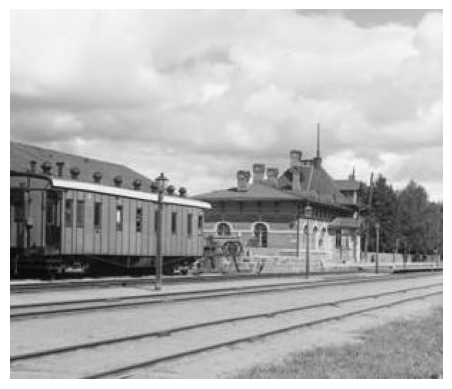

00398v


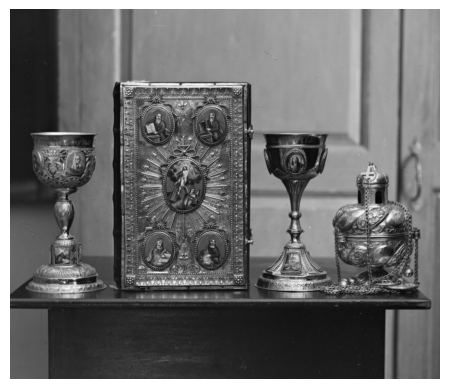

01047u


In [27]:
selected_names = [
    "00125v_aligned.jpg",
    "00351v_aligned.jpg",
    "00398v_aligned.jpg",
    "01047u_aligned.jpg"
]

# Build the dictionary
selected_images_dict = {}

# Add low-res and high-res images to the dictionary
for name in selected_names:
    key = name.replace('_aligned.jpg', '')
    # Try to find in high-res first
    if name in high_res_filenames:
        idx = high_res_filenames.index(name)
        selected_images_dict[key] = high_res_gray[idx]
    # If not found, try low-res
    elif name in low_res_filenames:
        idx = low_res_filenames.index(name)
        selected_images_dict[key] = low_res_gray[idx]
    else:
        print(f"Warning: {name} not found in either low-res or high-res images.")

# Print the keys of the selected images dictionary
print("Selected image keys:", selected_images_dict.keys())

# Plot the images
for name, image in selected_images_dict.items():
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    plt.show()
    print(f"{name}")

## Harris Corner Detector — Implementation Overview

The Harris corner detector was implemented to identify distinctive interest points where image intensity changes significantly in two directions. The goal was to obtain reliable corner locations to use later in the scale-space blob detection stage.

The implementation follows these main steps:

- **Gradient computation:** Sobel filters were used to calculate the horizontal and vertical image gradients, capturing local intensity changes.
- **Structure tensor formation:** The gradient products $I_x^2$, $I_y^2$, and $I_x I_y$ were combined into the structure tensor to represent local variation within a neighborhood.
- **Gaussian smoothing:** The tensor was smoothed with a Gaussian window to aggregate information over nearby pixels and reduce noise.
- **Corner response calculation:** The Harris response function  
  $$
  R = \det(H) - k \cdot (\operatorname{trace}(H))^2
  $$
  was applied to determine how corner-like each pixel is.
- **Peak selection:** Local maxima in the response map above a relative threshold were retained as final corners, up to a specified maximum number of peaks.

The detector was configured with `sigma_grad = 1.0`, `sigma_window = 1.5`, $k = 0.04$, `min_distance = 6`, `threshold_rel = 0.005`, and `max_peaks = 750`. These settings provided a balanced number of well-localized corners while suppressing noise. The detected corners served as input for the subsequent scale-space blob detection process.

In [28]:
# Default harris corner detection configurations
harris_configs = dict(
    sigma_grad=1.0,       # Gaussian smoothing scale for gradient estimation
    sigma_window=1.5,     # Gaussian window scale for structure tensor
    k=0.04,               # Harris detector free parameter (typically 0.04–0.06)
    min_distance=6,       # Minimum separation between detected corners (pixels)
    threshold_rel=0.005,  # Relative threshold for peak selection (fraction of max R)
    max_peaks=750         # Maximum number of corners to return
)

In [29]:
def compute_image_gradients(image, *, sigma_grad=1.0):
    """
    Estimate image gradients grad_x, grad_y.
    Args:
    - image: 2D numpy array (grayscale image)
    - sigma_grad: float, standard deviation for Gaussian smoothing
    Returns:
    - grad_x: 2D numpy array, gradient in x direction
    - grad_y: 2D numpy array, gradient in y direction
    """
    smoothed_image = filters.gaussian(image, sigma=sigma_grad, preserve_range=True, mode='reflect')
    grad_x = filters.sobel_h(smoothed_image)   # ∂I/∂x
    grad_y = filters.sobel_v(smoothed_image)   # ∂I/∂y
    return grad_x, grad_y

def compute_structure_tensor(grad_x, grad_y, *, sigma_window=1.5):
    """
    Build and smooth second-moment (structure) tensor entries in a local window.
      A = Gsigma * (grad_x^2),  B = Gsigma * (grad_y^2),  C = Gsigma * (grad_x*grad_y)
      where Gsigma is a Gaussian with sigma_window.
    Args:
    - grad_x: 2D numpy array, gradient in x direction
    - grad_y: 2D numpy array, gradient in y direction
    - sigma_window: float, standard deviation for Gaussian smoothing of tensor entries
    Returns:
    - tensor_xx: 2D numpy array, smoothed grad_x^2
    - tensor_yy: 2D numpy array, smoothed grad_y^2
    - tensor_xy: 2D numpy array, smoothed grad_x * grad_y
    """
    grad_xx = grad_x * grad_x
    grad_yy = grad_y * grad_y
    grad_xy = grad_x * grad_y

    tensor_xx = filters.gaussian(grad_xx, sigma=sigma_window, preserve_range=True, mode='reflect')
    tensor_yy = filters.gaussian(grad_yy, sigma=sigma_window, preserve_range=True, mode='reflect')
    tensor_xy = filters.gaussian(grad_xy, sigma=sigma_window, preserve_range=True, mode='reflect')
    return tensor_xx, tensor_yy, tensor_xy

def compute_harris_response(tensor_xx, tensor_yy, tensor_xy, *, k=0.04):
    """
    Harris response:
      det(H) - k * (trace(H))^2
      with H = [[tensor_xx, tensor_xy], [tensor_xy, tensor_yy]]
    Large positive R => likely corner (both eigenvalues large).
    Args:
    - tensor_xx: 2D numpy array, smoothed grad_x^2
    - tensor_yy: 2D numpy array, smoothed grad_y^2
    - tensor_xy: 2D numpy array, smoothed grad_x * grad_y
    - k: float, Harris detector free parameter (typically 0.04 - 0.06)
    Returns:
    - response: 2D numpy array, Harris corner response map
    """
    det_H   = tensor_xx * tensor_yy - tensor_xy * tensor_xy
    trace_H = tensor_xx + tensor_yy
    response = det_H - k * (trace_H ** 2)
    return response

def select_harris_corners(response, *, min_distance=6, threshold_rel=0.01, max_peaks=500):
    """
    Local maxima in response above relative threshold; enforce spatial separation.
    Returns Nx2 coordinates as (row=y, col=x).
    Args:
    - response: 2D numpy array, Harris corner response map
    - min_distance: int, minimum number of pixels separating peaks
    - threshold_rel: float, relative threshold for peak selection (fraction of max response)
    - max_peaks: int, maximum number of peaks to return
    Returns:
    - corner_coords: Nx2 numpy array of (row, col) coordinates of detected corners
    """
    corner_coords = feature.peak_local_max(
        response,
        min_distance=min_distance,
        threshold_rel=threshold_rel,
        num_peaks=max_peaks
    )
    return corner_coords

In [30]:
# Harris corner detection function
def harris_corner_detector(
    image, 
    sigma_grad=1.0, 
    sigma_window=1.5, 
    k=0.04, 
    min_distance=6, 
    threshold_rel=0.01, 
    max_peaks=500
):
    """
    Function to perform Harris corner detection on a grayscale image.
    Args:
        image: 2D numpy array, input grayscale image
        sigma_grad: float, Gaussian smoothing scale for gradient estimation
        sigma_window: float, Gaussian window scale for structure tensor
        k: float, Harris detector free parameter (typically 0.04–0.06)
        min_distance: int, minimum separation between detected corners (pixels)
        threshold_rel: float, relative threshold for peak selection (fraction of max R)
        max_peaks: int, maximum number of corners to return
    Returns:
        harris_response: 2D numpy array, Harris response image
        corner_coords: Nx2 numpy array, coordinates of detected corners (row, col)
    """
    # Step 1: Compute image gradients
    grad_x, grad_y = compute_image_gradients(image, sigma_grad=sigma_grad)
    # Step 2: Compute structure tensor components
    tensor_xx, tensor_yy, tensor_xy = compute_structure_tensor(grad_x, grad_y, sigma_window=sigma_window)
    # Step 3: Compute Harris response
    harris_response = compute_harris_response(tensor_xx, tensor_yy, tensor_xy, k=k)
    # Step 4: Select corners from the response
    corner_coords = select_harris_corners(
        harris_response, 
        min_distance=min_distance, 
        threshold_rel=threshold_rel, 
        max_peaks=max_peaks
    )
    # Return response and coordinates
    return harris_response, corner_coords

In [31]:
def plot_corner_overlay(image, corner_coords, title="Harris corners"):
    """
    Overlay detected corners on the image.
    Args:
        image: 2D numpy array, grayscale image
        corner_coords: Nx2 numpy array, coordinates of detected corners (row, col)
        title: str, plot title
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap='gray')
    if len(corner_coords) > 0:
        ax.plot(corner_coords[:, 1], corner_coords[:, 0], 'r.', markersize=3)
    ax.set_title(f"{title} — {len(corner_coords)} corners")
    ax.axis('off')
    plt.show()

In [32]:
# Entry function for Harris corner detection
def run_harris_on_selected_images(selected_images_dict, show=True):
    """
    Function to run harris corner detection on selected images.
    Args:
        selected_images_dict: dictionary containing selected images
        show: if True display the results
    Returns:
        results: dictionary with Harris corner detection results
    """
    results = {}
    for name, image in selected_images_dict.items():
        harris_response, corner_coords = harris_corner_detector(image, **harris_configs)
        if show:
            plot_corner_overlay(image, corner_coords, title=f"{name}")
        results[name] = {'response': harris_response, 'coords': corner_coords}
    return results

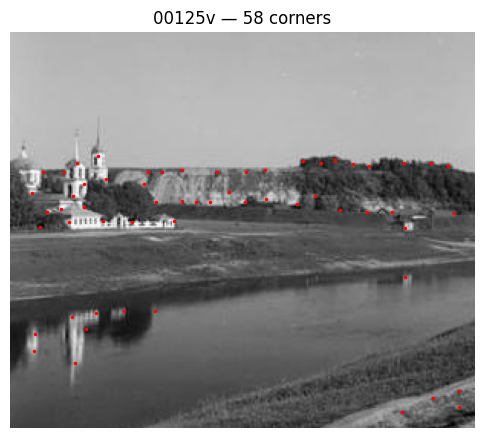

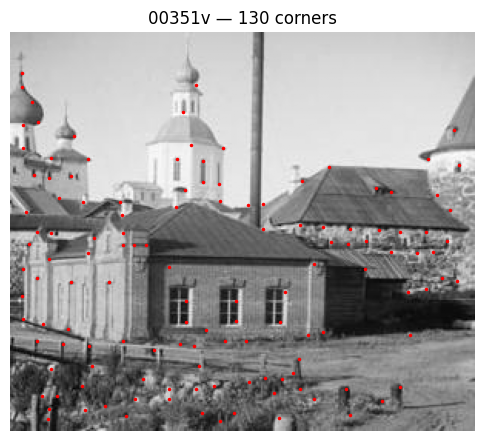

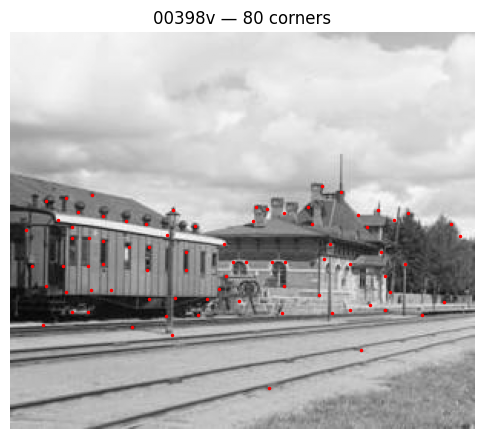

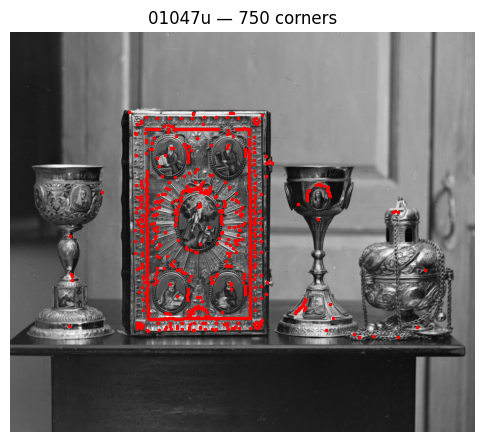

00125v corners: 58
00351v corners: 130
00398v corners: 80
01047u corners: 750


In [33]:
# Run Harris corner detection on selected images
harris_results = run_harris_on_selected_images(selected_images_dict, show=True)

# Print number of corners detected in each image
for k, v in harris_results.items():
    print(k, "corners:", len(v['coords']))

## Scale-Space Blob Detection — Implementation Flow

The scale-space blob detection stage extends the Harris corners across multiple scales to determine the most stable feature size and orientation. This approach makes the detector scale- and rotation-invariant by finding where each corner produces the strongest Laplacian-of-Gaussian (LoG) response and aligning it with its dominant gradient direction.

The overall process involves three main parts — scale-space construction, scale refinement, and orientation assignment — followed by visualization.

**1. Building the Scale-Space Representation**

To efficiently analyze features at different sizes, a LoG pyramid is built using the `build_scale_space_log_stack()` function.  
Instead of repeatedly applying very large Gaussian filters, the image is progressively downsampled and filtered at a fixed base scale ($\sigma_0 = 2.0$), then upsampled back to the original size.  
Each level represents a different blur or observation scale, defined by:

$$
\sigma_\ell = \sigma_0 \cdot k^\ell
$$

where $k = 1.2$ and the number of levels is set to $10$.  
This approach provides a good balance between computational efficiency and scale coverage while preserving the structural details needed for feature detection.

**2. Detecting and Refining Characteristic Scales**

For each Harris corner, the `detect_blob_scales()` function measures the scale-normalized LoG response across all levels.  
The level that yields the highest response indicates the characteristic scale, corresponding to the size at which the corner best represents a blob-like structure.

Since the scale-space is sampled at discrete intervals, the true maximum may fall between levels.  
To achieve more precise results, the `refine_blob_scales_quadratic()` function performs quadratic interpolation in log-scale space.  
It fits a parabola through three neighboring response values and calculates the vertex:

$$
x^* = -\frac{b}{2a}
$$

The refined value $e^{x^*}$ provides a smoother and more accurate estimate of the feature’s optimal scale, improving stability under varying imaging conditions.

**3. Assigning Dominant Orientation**

After determining the characteristic scale, the `dominant_orientations()` function estimates the dominant gradient direction for each feature.  
A circular neighborhood centered at the corner is analyzed, with the radius proportional to the detected scale.  
Gradient magnitudes and angles in this region are accumulated into a weighted histogram, and the peak of this histogram indicates the dominant orientation.  
This step ensures that detected features remain consistent under rotation.

**4. Visualization**

The final results are visualized using:
- Red dots for corner locations,
- Green circles with radii proportional to the detected scales, and
- Cyan arrows showing dominant orientations.

This visualization highlights how each corner extends into a multi-scale feature with a defined size and direction, confirming that the detector behaves consistently under translation, rotation, and scaling transformations.

### Refining Scale

Discrete scale levels can miss the true peak response.  
To improve accuracy, fit a quadratic in log-scale to the three LoG responses around the maximum and take the vertex to get a refined $\sigma^*$.

**Output:**  
Per-corner refined scales $\sigma^*$ (sub-level accuracy).

In [34]:
def refine_blob_scales_quadratic(scales, corner_responses, peak_levels):
    """
    Refine the characteristic scale for each corner using quadratic interpolation in log-scale space.

    Parameters
    ----------
    scales : (L,) np.ndarray
        Array of scale values (sigma) used to build the LoG stack.
    corner_responses : (L, N) np.ndarray
        LoG responses at each scale (L levels) for each of N corners.
    peak_levels : (N,) np.ndarray
        Discrete argmax level (index) per corner, i.e., the scale with the maximum response.

    Returns
    -------
    refined_scales : (N,) np.ndarray
        Refined (possibly sub-level) scale for each corner, using quadratic fit in log(sigma).
    """
    # Number of levels and corners
    num_levels, num_corners = corner_responses.shape
    # Logarithm of scales
    log_scales = np.log(scales)
    # Initialize refined scales with discrete best
    refined_scales = scales[peak_levels].astype(float).copy() 

    # Loop over each corner to refine its scale
    for i in range(num_corners):
        peak_idx = int(peak_levels[i])
        # Only refine if not at the boundary
        if 0 < peak_idx < num_levels - 1:
            # Get log-scales and responses for three neighboring levels
            x = log_scales[[peak_idx - 1, peak_idx, peak_idx + 1]]
            y = corner_responses[[peak_idx - 1, peak_idx, peak_idx + 1], i].astype(float)
            # Fit a parabola: y = a*x^2 + b*x + c
            a, b, _ = np.polyfit(x, y, 2)
            if abs(a) > 1e-12:
                # Vertex of the parabola gives refined log-scale
                refined_log_scale = -b / (2.0 * a)
                # Clamp to the local window
                refined_log_scale = np.clip(refined_log_scale, x.min(), x.max())
                refined_scales[i] = float(np.exp(refined_log_scale))  # Convert back to linear scale

    return refined_scales

### Building the Scale-Space LoG Stack

A multi-scale stack of scale-normalized Laplacian-of-Gaussian (LoG) responses is constructed using a downsampling approach:

- For each level $\ell$, the image is downsampled by $k^\ell$,
- Filtered at the fixed base scale $\sigma_0$,
- Then upsampled back to the original size,
- And the response is multiplied by $\sigma_\ell^2$ for scale normalization, where $\sigma_\ell = \sigma_0 \cdot k^\ell$.

**Output:**  
An LoG stack of shape $(L, H, W)$, aligned to the original image, and a list of effective scales $\{\sigma_\ell\}$ for each level.

In [35]:
def build_scale_space_log_stack(
    image_gray, sigma_base=2.0, scale_multiplier=1.25, num_levels=12
):
    """
    Build a scale-space stack of scale-normalized Laplacian-of-Gaussian (LoG) responses
    using a geometric scale pyramid and anti-aliased downsampling.

    Parameters
    ----------
    image_gray : 2D np.ndarray
        Input grayscale image.
    sigma_base : float
        Base scale (sigma_0) for LoG filtering at each level.
    scale_multiplier : float
        Multiplicative factor (k) between pyramid levels.
    num_levels : int
        Number of pyramid levels (L).

    Returns
    -------
    log_stack : (L, H, W) np.ndarray
        Scale-normalized LoG responses at each level, upsampled to original image size.
    effective_scales : (L,) np.ndarray
        Effective scale (sigma) at each level in original image coordinates.
    """

    # Convert input image to float32 for processing
    image = np.asarray(image_gray, dtype=np.float32, order="C")
    height, width = image.shape

    # Compute geometric scale levels: sigma = sigma_0 * k^level
    levels = np.arange(num_levels, dtype=int)
    effective_scales = sigma_base * (scale_multiplier ** levels)

    # Allocate stack for LoG responses at each scale
    log_stack = np.empty((num_levels, height, width), dtype=np.float32)

    # Process each pyramid level
    for level_idx, sigma in zip(levels, effective_scales):
        # Compute downsampling factor for this level
        downsample_factor = scale_multiplier ** level_idx

        # Compute downsampled image size (ensure at least 1 pixel in each dimension)
        height_ds = max(1, int(round(height / downsample_factor)))
        width_ds = max(1, int(round(width / downsample_factor)))

        # Downsample image with anti-aliasing, preserving intensity range
        image_ds = resize(
            image,
            (height_ds, width_ds),
            preserve_range=True,
            anti_aliasing=True,
            order=1,
        ).astype(np.float32)

        # Apply fixed-scale LoG filter (sigma_0) to downsampled image
        log_response_ds = gaussian_laplace(image_ds, sigma=float(sigma_base), mode="reflect")

        # Upsample LoG response back to original image size (bilinear, no anti-aliasing)
        log_response_up = resize(
            log_response_ds,
            (height, width),
            preserve_range=True,
            anti_aliasing=False,
            order=1,
        ).astype(np.float32)

        # Scale-normalize the response by (sigma)^2
        log_stack[level_idx] = (sigma ** 2) * log_response_up

    return log_stack, effective_scales

### Assigning Characteristic Scale to Corners

At each Harris corner, the LoG stack is sampled across all scales.  
The scale (level) with the maximum (normalized) response is selected as the discrete characteristic scale for that corner:

- **Input:** LoG stack and Harris corner coordinates
- **Process:** For each corner, take the `argmax` of the LoG response across all levels
- **Output:** For each corner, record the winning level, the response value, and the corresponding scale $\sigma_\ell = \sigma_0 \cdot k^\ell$

In [36]:
def detect_blob_scales(image, corner_coords, sigma0=2.0, k=1.25, num_levels=12, return_stack=False):
    """
    Assign a characteristic scale to each Harris corner using a
    scale-normalized LoG pyramid (fixed sigma0 per level) plus 3-point
    quadratic refinement in log(sigma).

    Parameters
    ----------
    image : 2D np.ndarray
        Input grayscale image.
    corner_coords : (N, 2) np.ndarray
        Harris corner coordinates (row, col).
    sigma0 : float
        Base scale for LoG filtering.
    k : float
        Multiplicative factor between pyramid levels.
    num_levels : int
        Number of pyramid levels.
    return_stack : bool
        If True, also return the full LoG stack and scales.

    Returns
    -------
    sigmas_refined : (N,) np.ndarray
        Refined scales per corner.
    best_levels : (N,) np.ndarray
        Discrete winning level index per corner.
    best_values : (N,) np.ndarray
        Response value at winning level per corner.
    [stack, scales] : optional
        If return_stack=True, also returns (L,H,W) stack and (L,) scales.
    """

    # 1. Build the scale-space LoG stack and get the effective scales
    log_stack, scales = build_scale_space_log_stack(
        image_gray=image,
        sigma_base=sigma0,
        scale_multiplier=k,
        num_levels=num_levels
    )

    # 2. Sample LoG responses at each corner across all scales
    H, W = log_stack.shape[1:]
    # Ensure corner_coords is a numpy array
    corner_coords = np.asarray(corner_coords)
    # Clip and round the coordinates to be within image bounds
    rows = np.clip(np.round(corner_coords[:, 0]).astype(int), 0, H - 1)
    cols = np.clip(np.round(corner_coords[:, 1]).astype(int), 0, W - 1)
    # Sample the LoG responses at the rounded coordinates
    corner_responses = log_stack[:, rows, cols]

    # 3. Find the best scale (level) for each corner
    best_levels = np.argmax(corner_responses, axis=0)
    # Get the best response values at the best levels
    best_values = corner_responses[best_levels, np.arange(corner_responses.shape[1])]

    # 4. Refine the scale using quadratic interpolation in log(sigma)
    sigmas_refined = refine_blob_scales_quadratic(scales, corner_responses, best_levels)

    if return_stack:
        return sigmas_refined, best_levels, best_values, log_stack, scales
    return sigmas_refined, best_levels, best_values

### Orientation at the Chosen Scale

Within a circular window with radius proportional to $\sigma^*$,  
build a magnitude-weighted orientation histogram and take the peak as the dominant orientation $\theta^*$.

**Output:**  
Per-corner orientations $\theta^*$ in $[0, 2\pi)$.

In [37]:
def dominant_orientations(img_gray, corner_coords, scales, radius_factor=np.sqrt(2.0), num_bins=36):
    """
    For each corner, compute the dominant gradient orientation in a circular window
    of radius = radius_factor * scale, weighted by gradient magnitude.

    Parameters
    ----------
    img_gray : 2D np.ndarray
        Grayscale image.
    corner_coords : (N, 2) np.ndarray
        Array of (row, col) coordinates for each corner.
    scales : (N,) np.ndarray
        Characteristic scale (sigma) for each corner.
    radius_factor : float
        Multiplier for the window radius (default sqrt(2)).
    num_bins : int
        Number of bins for orientation histogram (default 36).

    Returns
    -------
    orientations : (N,) np.ndarray
        Dominant orientation (in radians, [0, 2π)) for each corner.
    """

    # Compute image gradients (Sobel)
    grad_x = sobel(img_gray, axis=1, mode='reflect')
    grad_y = sobel(img_gray, axis=0, mode='reflect')
    # Compute gradient magnitude and angle
    grad_magnitude = np.hypot(grad_x, grad_y)
    # Angle in [0, 2π)
    grad_angle = (np.arctan2(grad_y, grad_x) + 2 * np.pi) % (2 * np.pi)

    # Precompute meshgrid for window extraction
    img_height, img_width = img_gray.shape
    # Create meshgrid
    yy, xx = np.indices((img_height, img_width))
    
    # Compute the number of corners and initialize orientation array
    num_corners = len(scales)
    # Ensure scales is a numpy array
    orientations = np.zeros(num_corners, dtype=np.float32)
    # Create histogram bin edges
    bin_edges = np.linspace(0.0, 2 * np.pi, num_bins + 1)

    # For each corner, compute the dominant orientation
    for i, ((row, col), sigma) in enumerate(zip(np.round(corner_coords).astype(int), scales)):
        # Define circular window radius
        window_radius = float(radius_factor * sigma)
        
        # Clamp center to image bounds
        row = int(np.clip(row, 0, img_height - 1))
        col = int(np.clip(col, 0, img_width - 1))
        
        # Compute window bounds
        row_min = max(0, int(row - window_radius))
        row_max = min(img_height, int(row + window_radius + 1))
        col_min = max(0, int(col - window_radius))
        col_max = min(img_width, int(col + window_radius + 1))

        # Extract window meshgrid
        window_yy = yy[row_min:row_max, col_min:col_max]
        window_xx = xx[row_min:row_max, col_min:col_max]
        
        # Create circular mask
        # The equation of a circle: (x - h)^2 + (y - k)^2 <= r^2
        mask = (window_yy - row) ** 2 + (window_xx - col) ** 2 <= window_radius ** 2

        # Extract gradient magnitude and angle within the window
        window_magnitude = grad_magnitude[row_min:row_max, col_min:col_max][mask]
        window_angle = grad_angle[row_min:row_max, col_min:col_max][mask]

        # Compute dominant orientation if there are pixels in the window
        if window_magnitude.size != 0:
            # Build weighted orientation histogram
            hist, _ = np.histogram(window_angle, bins=bin_edges, weights=window_magnitude)
            max_bin = int(np.argmax(hist))
            # Assign orientation as the center of the max bin
            orientations[i] = float(0.5 * (bin_edges[max_bin] + bin_edges[max_bin + 1]) % (2 * np.pi))

    return orientations

In [38]:
# Compute and store best scales for each image
blob_scale_results = {}

for name, image in selected_images_dict.items():
    coords = harris_results[name]['coords']

    # Scale assignment
    # Call the refactored detect_blob_scales function
    sigmas_refined, best_levels, best_values, log_stack, scale_list = detect_blob_scales(
        image=image,
        corner_coords=coords,
        sigma0=2.0,
        k=1.2,
        num_levels=10,
        return_stack=True
    )

    # Orientation assignment
    # Call the refactored dominant_orientations function
    orientations = dominant_orientations(
        img_gray=image,
        corner_coords=coords,
        scales=sigmas_refined,
        radius_factor=np.sqrt(2.0),
        num_bins=36
    )

    # Save the results
    blob_scale_results[name] = {
        "coords": coords,
        "scales": sigmas_refined,
        "orientations": orientations,
        "best_levels": best_levels,
        "best_values": best_values,
    }

In [39]:
def overlay_x_circle_arrow(
    ax,
    corners_rc,          # (N,2) rows, cols
    sigmas,              # (N,)
    thetas,              # (N,) radians in [0, 2π)
    radius_factor=np.sqrt(2.0),
    x_color='y',
    circ_color='red',
    arrow_color='c',
    lw=1.5,
    arrow_scale=1.0,     # 1.0 uses radius as arrow length
):
    """
    Overlay corner visualizations on an image axis.

    Draws:
      - 'x' at each corner location,
      - a circle with radius proportional to sigma,
      - an arrow indicating the dominant orientation.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis to draw on (should already display the image).
    corners_rc : (N,2) array-like
        Corner coordinates as (row, col).
    sigmas : (N,) array-like
        Scale (sigma) for each corner.
    thetas : (N,) array-like
        Orientation (radians, [0, 2π)) for each corner.
    radius_factor : float
        Multiplier for the circle radius (default sqrt(2.0)).
    x_color : str
        Color for the 'x' marker.
    circ_color : str
        Color for the circle.
    arrow_color : str
        Color for the orientation arrow.
    lw : float
        Line width for drawing.
    arrow_scale : float
        Multiplier for arrow length (default 1.0).
    """
    # Convert inputs to float arrays for consistency
    corners_rc = np.asarray(corners_rc, dtype=float)
    sigmas = np.asarray(sigmas, dtype=float)
    thetas = np.asarray(thetas, dtype=float)

    # Loop over each corner to draw
    for (row, col), sigma, theta in zip(corners_rc, sigmas, thetas):
        radius = float(radius_factor * sigma)

        # Draw 'x' at the corner location
        ax.scatter([col], [row], s=20, c=x_color, marker='x', linewidths=lw)

        # Draw a circle scaled by sigma
        circ = plt.Circle((col, row), radius=radius, edgecolor=circ_color, facecolor='none', linewidth=lw)
        ax.add_patch(circ)

        # Draw orientation arrow (image coordinates: +row is down)
        d_row = -arrow_scale * radius * np.sin(theta)   # negative for image row direction
        d_col =  arrow_scale * radius * np.cos(theta)
        # Draw the arrow
        ax.arrow(
            col, row, d_col, d_row,
            head_width=0.12 * radius,
            head_length=0.18 * radius,
            length_includes_head=True,
            edgecolor=arrow_color,
            facecolor=arrow_color,
            linewidth=lw,
        )

Each detected corner is visualized with:
- an “x” at the corner location,
- a circle whose radius is proportional to the detected scale (σ*),
- and an arrow indicating the dominant orientation (θ*).

This visualization demonstrates both the detected scale and orientation for each feature.

Image: 00125v
  Number of corners: 58
  Sigma (scale) stats: mean=6.37, std=3.76, min=2.00, max=10.32
  Orientation (theta) stats: mean=3.71 rad, std=1.64 rad



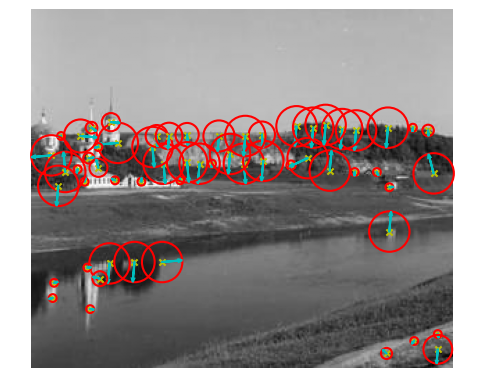

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00125v.jpeg
Image: 00351v
  Number of corners: 130
  Sigma (scale) stats: mean=6.76, std=3.48, min=2.00, max=10.32
  Orientation (theta) stats: mean=3.11 rad, std=1.98 rad



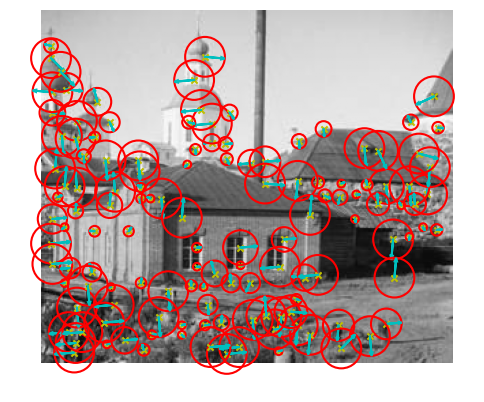

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00351v.jpeg
Image: 00398v
  Number of corners: 80
  Sigma (scale) stats: mean=7.42, std=3.37, min=2.00, max=10.32
  Orientation (theta) stats: mean=3.51 rad, std=1.71 rad



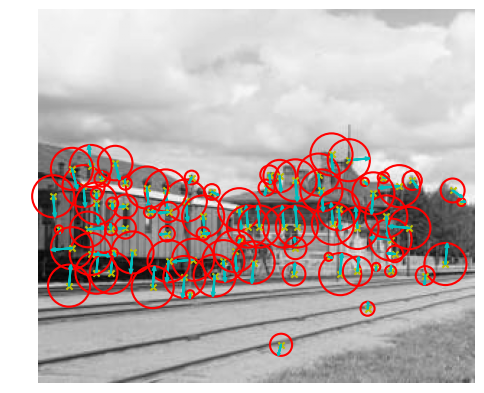

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00398v.jpeg
Image: 01047u
  Number of corners: 750
  Sigma (scale) stats: mean=6.27, std=3.66, min=2.00, max=10.32
  Orientation (theta) stats: mean=3.16 rad, std=1.59 rad



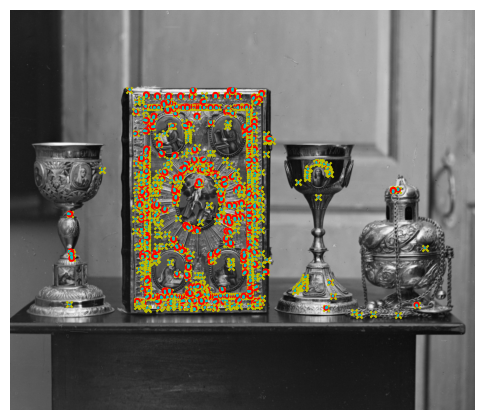

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/01047u.jpeg


In [40]:
# Directory to save output images
output_dir = os.path.abspath(os.path.join(os.getcwd(), "../Gen/a2/part2/"))
os.makedirs(output_dir, exist_ok=True)

# Visualize results with overlays
for name, image in selected_images_dict.items():
    img_gray = image
    # Extract coordinates, scales, and orientations
    coords = blob_scale_results[name]["coords"]
    sigmas_refined = blob_scale_results[name]["scales"]
    orientations = blob_scale_results[name]["orientations"]
    
    # Print statistics
    print(f"Image: {name}")
    print(f"  Number of corners: {len(coords)}")
    # Compute the mean, std, min, max of scales and orientations
    print(f"  Sigma (scale) stats: mean={np.mean(sigmas_refined):.2f}, std={np.std(sigmas_refined):.2f}, min={np.min(sigmas_refined):.2f}, max={np.max(sigmas_refined):.2f}")
    print(f"  Orientation (theta) stats: mean={np.mean(orientations):.2f} rad, std={np.std(orientations):.2f} rad")
    print()
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img_gray, cmap='gray')
    ax.axis('off')
    # Call function to draw circles, arrows, and 'x's
    overlay_x_circle_arrow(
        ax,
        corners_rc=coords,
        sigmas=sigmas_refined,
        thetas=orientations,
        radius_factor=np.sqrt(2.0)
    )
   
    # Save the plot with the original image name
    save_name = f"{name}.jpeg"
    save_path = os.path.join(output_dir, save_name)
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.05, dpi=150)
    plt.show()
    print(f"Saved: {save_path}")

## Invariance Analysis: Harris + LoG + Orientation under Geometric Transformations

Evaluate the invariance of the Harris corner detector, scale selection (via Laplacian-of-Gaussian), and orientation assignment under various geometric transformations.  
For each selected image, apply a set of transformations (shift, rotation, scaling), then:
1. Detect Harris corners on the transformed image.
2. Assign a characteristic scale to each corner using a scale-normalized LoG pyramid.
3. Compute the dominant orientation for each corner.
4. Visualize the detected features (corner location, scale, and orientation) using an overlay of X, circle, and arrow.
5. Print the number of detected corners for each transformation.

This analysis helps demonstrate the robustness of the feature detection to translation, rotation, and scale changes.

### Transformation Functions for Invariance Analysis

The following functions perform image transformations (shift, rotation, scaling) used in the invariance analysis. These transformations are applied to test the robustness of the feature detection.

In [41]:
def shift_image_left_and_crop(image, fraction=0.20):
    """
    Shift the image to the LEFT by a given fraction of its width and crop to original size.

    Args:
        image (ndarray): 2D numpy array (grayscale image).
        fraction (float): Fraction of the width to shift left (default 0.20).

    Returns:
        ndarray: Shifted and cropped image of the same shape as input.
    """
    H, W = image.shape
    shift = int(round(fraction * W))
    canvas = np.zeros_like(image)
    canvas[:, :-shift] = image[:, shift:]
    return canvas

def shift_image_right_and_crop(image, fraction=0.20):
    """
    Shift the image to the RIGHT by a given fraction of its width and crop to original size.

    Args:
        image (ndarray): 2D numpy array (grayscale image).
        fraction (float): Fraction of the width to shift right (default 0.20).

    Returns:
        ndarray: Shifted and cropped image of the same shape as input.
    """
    H, W = image.shape
    shift = int(round(fraction * W))
    canvas = np.zeros_like(image)
    canvas[:, shift:] = image[:, :-shift]
    return canvas

def rotate_image_ccw_90(image):
    """
    Rotate the image 90 degrees counterclockwise.

    Args:
        image (ndarray): 2D numpy array (grayscale image).

    Returns:
        ndarray: Rotated image.
    """
    return np.rot90(image, k=1)

def rotate_image_cw_90(image):
    """
    Rotate the image 90 degrees clockwise.

    Args:
        image (ndarray): 2D numpy array (grayscale image).

    Returns:
        ndarray: Rotated image.
    """
    return np.rot90(image, k=-1)

def scale_image_2x_and_center_crop(image):
    """
    Enlarge the image by a factor of 2 and center-crop back to original size.

    This operation keeps the field-of-view consistent with the assignment requirements.

    Args:
        image (ndarray): 2D numpy array (grayscale image).

    Returns:
        ndarray: Scaled and center-cropped image of the same shape as input.
    """
    H, W = image.shape
    enlarged = resize(image, (2 * H, 2 * W), order=1, anti_aliasing=True, preserve_range=True)
    y0 = (2 * H - H) // 2
    x0 = (2 * W - W) // 2
    return enlarged[y0:y0 + H, x0:x0 + W]

In [42]:
# List of all transformation functions to test
transformations = [
    ("shift_left", shift_image_left_and_crop),
    ("shift_right", shift_image_right_and_crop),
    ("rotate_ccw_90", rotate_image_ccw_90),
    ("rotate_cw_90", rotate_image_cw_90),
    ("scale_2x_center_crop", scale_image_2x_and_center_crop),
]

00125v [shift_left]: 44 corners


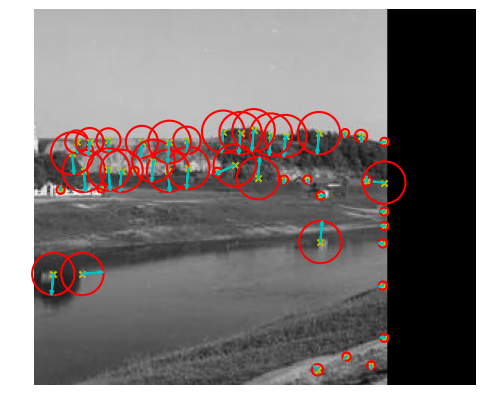

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00125v_shift_left.jpeg
00351v [shift_left]: 90 corners


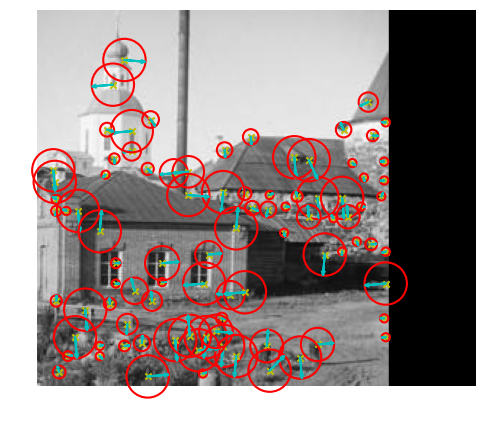

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00351v_shift_left.jpeg
00398v [shift_left]: 64 corners


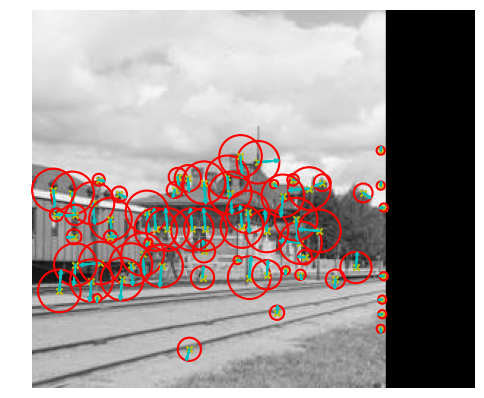

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00398v_shift_left.jpeg
01047u [shift_left]: 750 corners


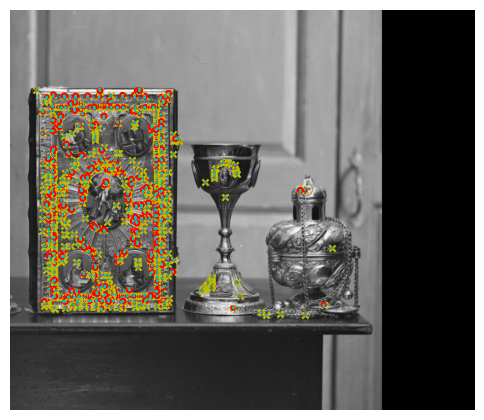

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/01047u_shift_left.jpeg
00125v [shift_right]: 52 corners


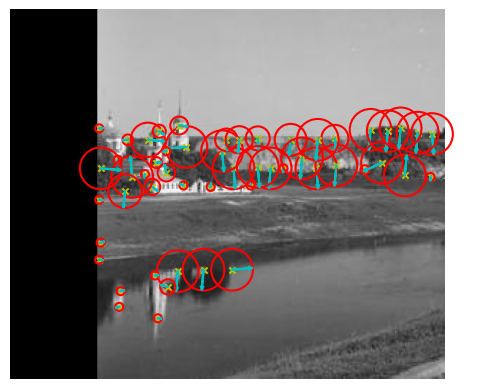

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00125v_shift_right.jpeg
00351v [shift_right]: 110 corners


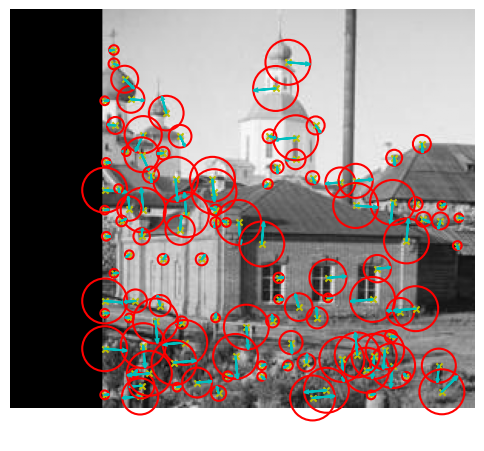

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00351v_shift_right.jpeg
00398v [shift_right]: 75 corners


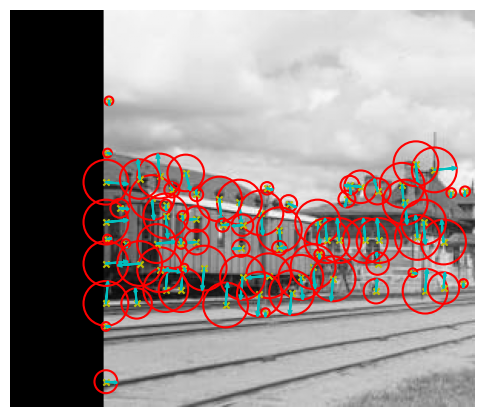

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00398v_shift_right.jpeg
01047u [shift_right]: 750 corners


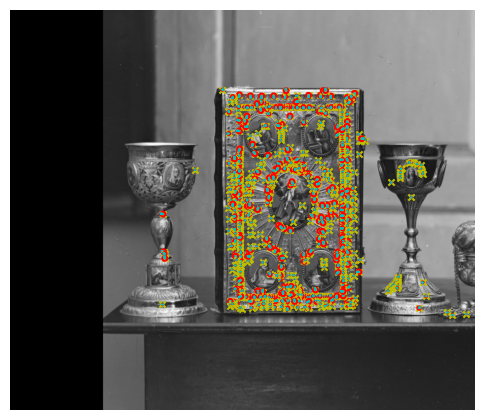

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/01047u_shift_right.jpeg
00125v [rotate_ccw_90]: 58 corners


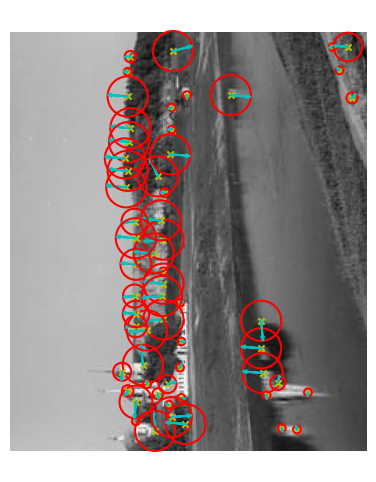

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00125v_rotate_ccw_90.jpeg
00351v [rotate_ccw_90]: 130 corners


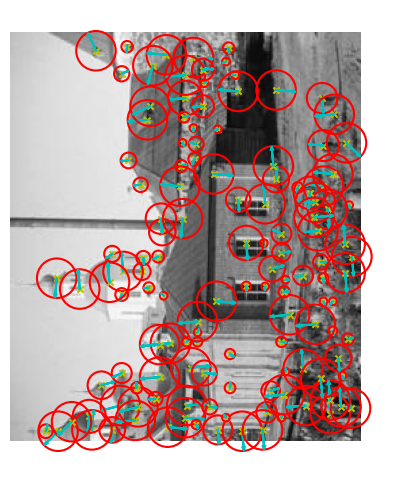

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00351v_rotate_ccw_90.jpeg
00398v [rotate_ccw_90]: 80 corners


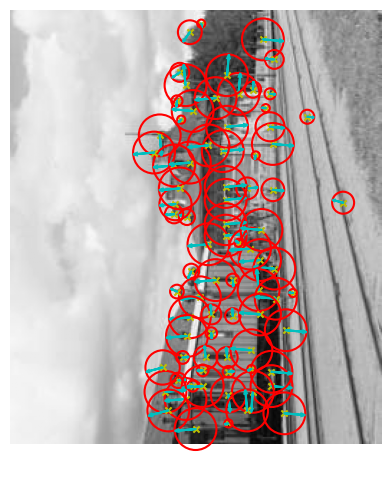

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00398v_rotate_ccw_90.jpeg
01047u [rotate_ccw_90]: 750 corners


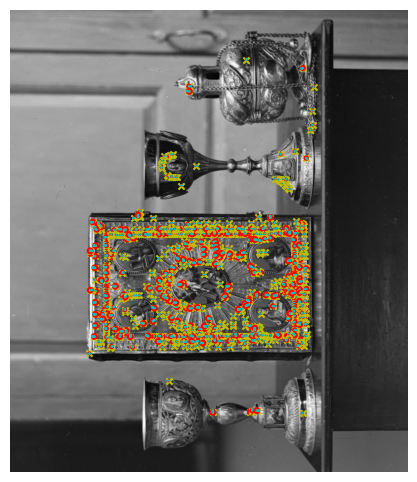

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/01047u_rotate_ccw_90.jpeg
00125v [rotate_cw_90]: 58 corners


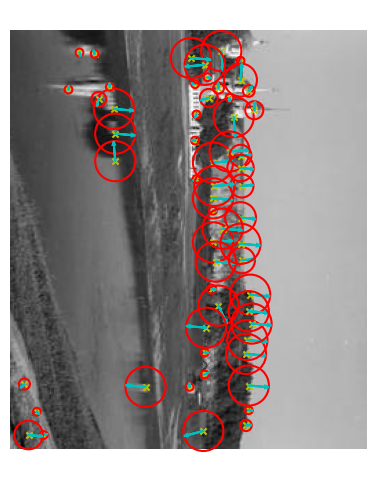

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00125v_rotate_cw_90.jpeg
00351v [rotate_cw_90]: 130 corners


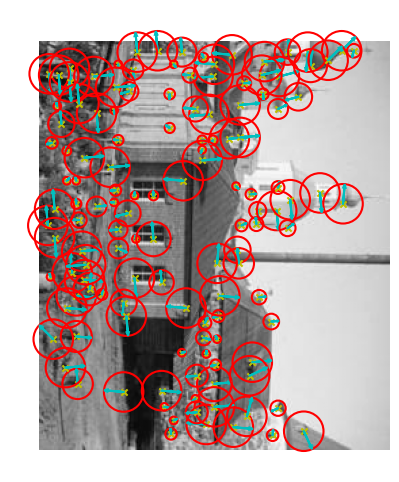

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00351v_rotate_cw_90.jpeg
00398v [rotate_cw_90]: 80 corners


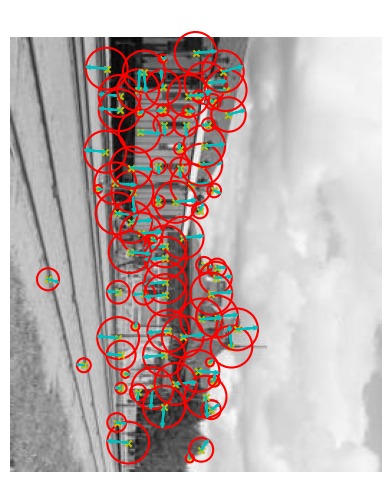

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00398v_rotate_cw_90.jpeg
01047u [rotate_cw_90]: 750 corners


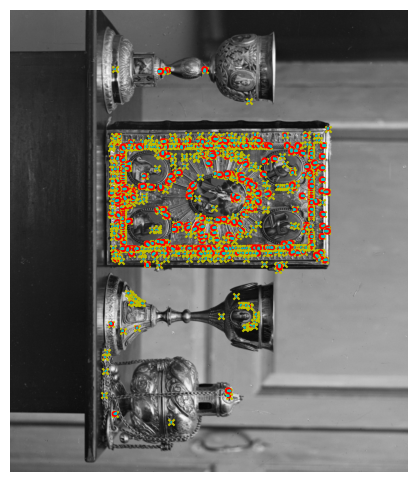

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/01047u_rotate_cw_90.jpeg
00125v [scale_2x_center_crop]: 52 corners


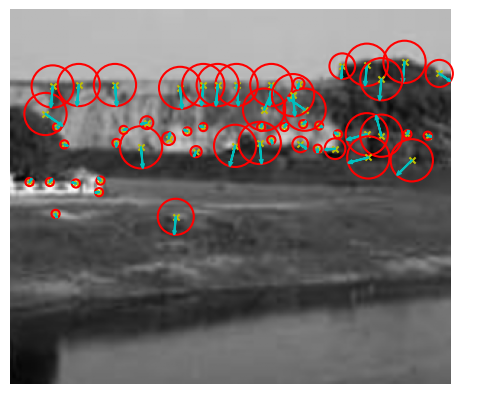

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00125v_scale_2x_center_crop.jpeg
00351v [scale_2x_center_crop]: 79 corners


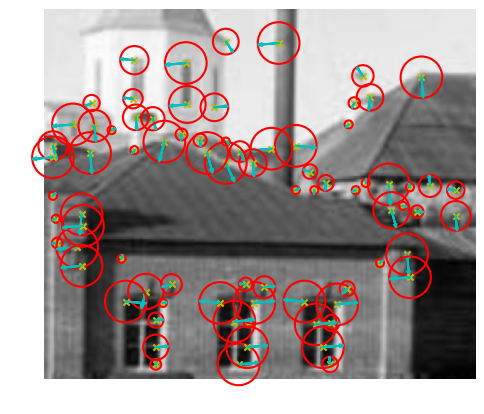

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00351v_scale_2x_center_crop.jpeg
00398v [scale_2x_center_crop]: 101 corners


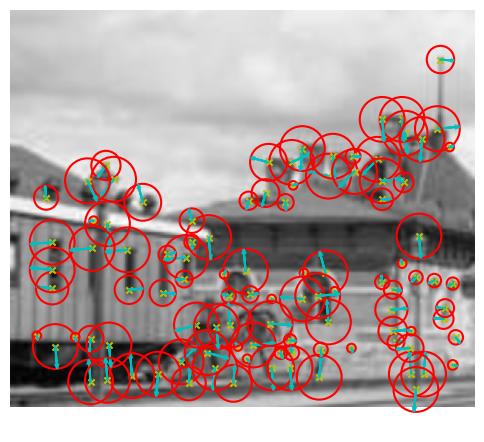

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/00398v_scale_2x_center_crop.jpeg
01047u [scale_2x_center_crop]: 750 corners


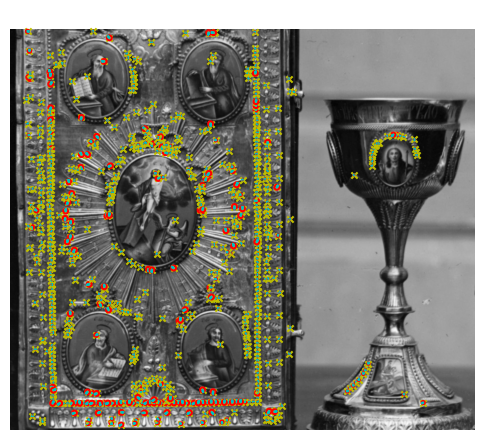

Saved: /Users/rashiqul/Documents/Workspace/ece549/Gen/a2/part2/01047u_scale_2x_center_crop.jpeg


In [43]:
# Directory to save output images
output_dir = os.path.abspath(os.path.join(os.getcwd(), "../Gen/a2/part2/"))
os.makedirs(output_dir, exist_ok=True)

# Apply transformations and run detection
for tname, tfunc in transformations:
    for name, image in selected_images_dict.items():
        # 1. Apply transformation
        transformed_image = tfunc(image)
        # 2. Harris corner detection
        harris_response, transformed_corners = harris_corner_detector(
            transformed_image, **harris_configs
        )
        # 3. Laplacian of Gaussian (LoG) blob scale detection
        sigmas_refined, best_levels, best_values = detect_blob_scales(
            image=transformed_image,
            corner_coords=transformed_corners,
            sigma0=2.0,
            k=1.2,
            num_levels=10,
            return_stack=False
        )
        # 4. Orientation assignment
        orientations = dominant_orientations(
            img_gray=transformed_image,
            corner_coords=transformed_corners,
            scales=sigmas_refined,
            radius_factor=np.sqrt(2.0),
            num_bins=36
        )
        # 5. Print stats and visualize
        print(f"{name} [{tname}]: {len(transformed_corners)} corners")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(transformed_image, cmap='gray')
        ax.axis('off')
        overlay_x_circle_arrow(
            ax,
            corners_rc=transformed_corners,
            sigmas=sigmas_refined,
            thetas=orientations,
            radius_factor=np.sqrt(2.0)
        )
        # Save the plot
        save_name = f"{name}_{tname}.jpeg"
        save_path = os.path.join(output_dir, save_name)
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.05, dpi=150)
        plt.show()
        print(f"Saved: {save_path}")